In [353]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu
import pickle
import unidecode
import spacy
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stopwords.words('french')
stop_words.extend(['avis','environnement','autorite','projet','etude','exploitation','impact','site','dossier','mission','regionale','mrae','mnhn'])

nlp = spacy.load('fr_core_news_sm')
# Read recipe inputs
avis_Id_Text_Preprocessed_joined = dataiku.Dataset("Avis_Id_Text_Preprocessed_joined")
avis_Id_Text_Preprocessed_joined_df = avis_Id_Text_Preprocessed_joined.get_dataframe()
thesaurus = dataiku.Folder("XXZ13n5V")
thesaurus_info = thesaurus.get_info()
path = thesaurus.get_path()

## 0. Préparation du Thesaurus et des données

Preprocessing a appliquer sur le thesaurus. Attention, il faudra appliquer le même processing sur les textes pour reconnaitre les mots du thesaurus !


In [354]:
def processing_mot(text):
    prepro = nlp(text)
    lem = ' '.join(token.lemma_ for token in prepro if token.lemma_ not in stop_words and not len(token.text)<=2 )
    s = re.sub(r'[^\w\s]','',lem)
    s = re.sub('  ',' ',s)
    s = s.lower()
    s = unidecode.unidecode(s)
    return(s)

In [359]:
Thesaurus = pickle.load(open(path+'/Thesaurus1.pickle','rb'))
thesau_list_unpro = list(Thesaurus.Dictionnaire.values)
enjeux_list = list(Thesaurus['Enjeu environnemental'].values)
thesau_list = []
for enjeu in thesau_list_unpro:
    thesau_list.append([processing_mot(mot) for mot in enjeu if mot != ''])

dicoThesau = {k:v for k,v in zip(enjeux_list,thesau_list)}
dicoThesau

{'Biodiversité': ['biodiversite',
  'milieu naturel',
  'habitat naturel',
  'faun',
  'flore',
  'trame vert bleu tvb',
  'trame noir',
  'pollution lumineux',
  'reservoir biologique',
  'continuite ecologique',
  'haie',
  'boisement',
  'prairie',
  'bocage',
  'milieu aquatique',
  'cours eau',
  'etat ecologique',
  'pollution',
  'debit reserver',
  'zone humide',
  'znieff',
  'natura 2000',
  'espece proteger',
  'oiseau',
  'chauve souris',
  'avifaun',
  'mammifere',
  'poisson',
  'insecte',
  'herbier',
  'trame vert bleu',
  'tvb',
  'debit reservir',
  'espec protegee'],
 'Paysage et qualité de vie': ['paysage',
  'cadre vie',
  'qualite vie',
  'integration paysager',
  'photomontage',
  'insertion visuelle',
  'point vue',
  'covisibilite',
  'monument historique',
  'inscrire',
  'classer',
  'nuisance',
  'commodite',
  'bruit',
  'vibration',
  'acoustique',
  'emergence',
  '',
  'exposition',
  'odeur',
  'olfactif',
  'insertion',
  'commodit',
  'incommode'],
 '

In [360]:
Thesaurus

,Enjeu environnemental,Dictionnaire
0,Biodiversité,"[biodiversité, milieu naturel, habitat naturel..."
1,Paysage et qualité de vie,"[paysage, cadre de vie, qualité de vie, intégr..."
2,Santé et sécurité des personnes,"[santé humaine, toxicité, bactériologique, qua..."
3,"Effets globaux (climat, énergie, ressources...)","[climat, changement climatique, réchauffement,..."
4,Préservation des sols,"[sols, artificialisation, consommation foncièr..."
5,Qualité de l’eau et ressource,"[eaux usées, eaux pluviales, eau de pluie, hyd..."
6,Déplacements,"[déplacements, transport, mobilité, véhicules,..."
7,Gestion des déchets,"[déchets, épandage, compostage, recyclage, mét..."


In [361]:
docs_df = avis_Id_Text_Preprocessed_joined_df.drop(['url_etude','url_avis','departement','titre','theme'],axis = 1)
docs_df.head(5)

,text_preprocessed,id_AAE
0,rae mission regionale autorite environnemental...,1008101
1,ivrae mission regionale autorite environnement...,101872
2,ivrab mission regionale autorite environnement...,102316
3,mwe mission regionale autorite environnemental...,1061090
4,krae mission regionale autorite environnementa...,106168


In [364]:
from tqdm import tqdm
tqdm.pandas(desc="Processing text")
def processing(text):
    text = nlp(text)
    string = unidecode.unidecode(' '.join([token.lemma_ for token in text if token.text not in stop_words and not len(token.text)<=2 ]))
    string = re.sub(r'[^\w\s]','',string)
    string = re.sub(r'  ',' ',string)
    return(string)

docs_df['text_processed'] = docs_df.text_preprocessed.progress_apply(processing)
docs_df.drop(['text_preprocessed'],axis = 1,inplace = True)

Processing text: 100%|██████████| 318/318 [04:32<00:00,  1.17it/s]


In [365]:
docs_df

,id_AAE,text_processed
0,1008101,rae environnemental auvergn alpes delibere env...
1,101872,ivra environnemental pays loir avisd environne...
2,102316,ivrab environnemental region nouveau aquitaine...
3,1061090,mw environnemental occitanie environnemental r...
4,106168,krae environnemental grand parc eolien situe c...
...,...,...
313,364910,liberte egalite fraternite republiqu francais ...
314,393541,rae environnemental region nouveau aquitaine e...
315,431481,libtrtt egalite fratrrniti republiqu francais ...
316,496260,praa environnemental normandie delibere enviro...


## 1. Analyse du vocabulaire existant

On vectorise les données et on crée des listes pratiques pour manipuler les noms de features, etc...


In [366]:
countVecto = CountVectorizer(min_df = 0, max_df = 0.9, ngram_range=(1,3), stop_words = stop_words)
process = countVecto.fit_transform(docs_df.text_processed.values)  
word2id = countVecto.vocabulary_
vocab = tuple(word2id.keys())
cov = {}
size = [len(vocab)]
for words,enjeu in zip(thesau_list,enjeux_list):
    t = len(words)
    c = 0
    for word in words:
        if word in vocab:
            c+=1
    cov[enjeu] = [c/t]
    
for k in range(1,30):
    countVecto = CountVectorizer(min_df = k, max_df = 0.9, ngram_range=(1,3), stop_words = stop_words)
    process = countVecto.fit_transform(docs_df.text_processed.values)  
    word2id = countVecto.vocabulary_
    vocab = tuple(word2id.keys())
    size.append(len(vocab))
    for words,enjeu in zip(thesau_list,enjeux_list):
        t = len(words)
        c = 0
        for word in words:
            if word in vocab:
                c+=1
        cov[enjeu].append(c/t)

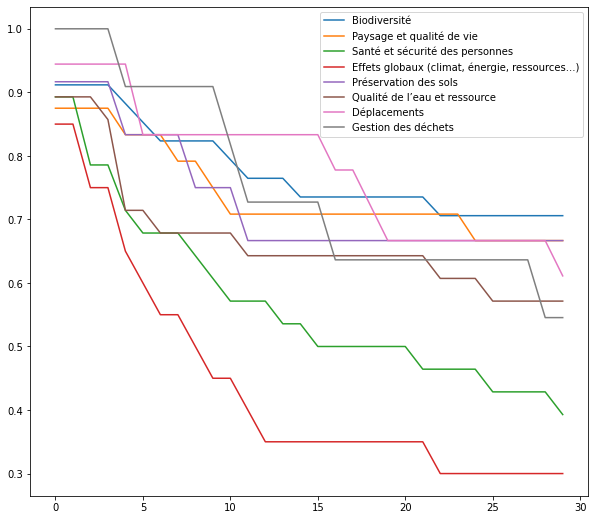

[1011455,
 1011455,
 178573,
 74870,
 48240,
 34958,
 27668,
 22879,
 19329,
 16974,
 14916,
 13471,
 12288,
 11240,
 10355,
 9625,
 8982,
 8413,
 7887,
 7354,
 6992,
 6631,
 6255,
 5963,
 5678,
 5420,
 5149,
 4965,
 4765,
 4607]

In [367]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
for enjeu in enjeux_list:
    plt.plot([k for k in range(30)],cov[enjeu],label = enjeu)

plt.legend(loc = 1)
plt.show()
size

In [380]:
countVecto = CountVectorizer(min_df = 0, max_df = 1, ngram_range=(1,3), stop_words = stop_words)
process = countVecto.fit_transform(docs_df.text_processed.values)  
word2id = countVecto.vocabulary_
vocab = tuple(word2id.keys())
cov = {}
size = [len(vocab)]
for words,enjeu in zip(thesau_list,enjeux_list):
    t = len(words)
    c = 0
    for word in words:
        if word in vocab:
            c+=1
    cov[enjeu] = [c/t]
    
for k in range(1,30):
    countVecto = CountVectorizer(min_df = 0, max_df = 1-k/100, ngram_range=(1,3), stop_words = stop_words)
    process = countVecto.fit_transform(docs_df.text_processed.values)  
    word2id = countVecto.vocabulary_
    vocab = tuple(word2id.keys())
    size.append(len(vocab))
    for words,enjeu in zip(thesau_list,enjeux_list):
        t = len(words)
        c = 0
        for word in words:
            if word in vocab:
                c+=1
        cov[enjeu].append(c/t)

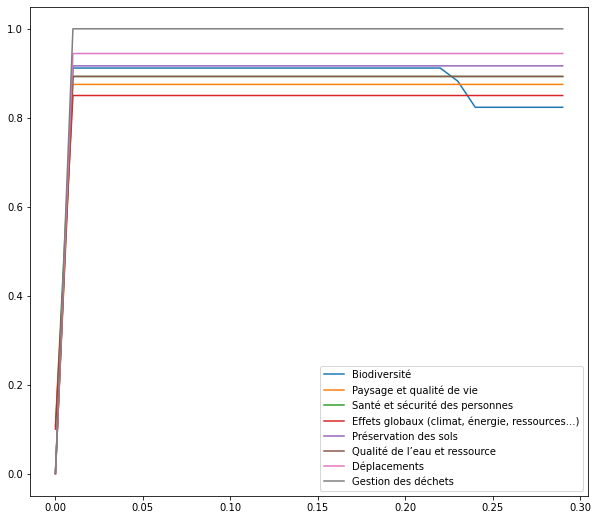

[832882,
 1011527,
 1011520,
 1011514,
 1011508,
 1011497,
 1011485,
 1011473,
 1011470,
 1011463,
 1011455,
 1011452,
 1011443,
 1011437,
 1011430,
 1011421,
 1011415,
 1011404,
 1011400,
 1011389,
 1011379,
 1011371,
 1011359,
 1011341,
 1011331,
 1011322,
 1011315,
 1011308,
 1011296,
 1011281]

In [381]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
for enjeu in enjeux_list:
    plt.plot([k/100 for k in range(30)],cov[enjeu],label = enjeu)

plt.legend(loc = 0)
plt.show()
size

A partir des évaluations précédentes, il faut choisir les paramètres de manière a garder le plus grand nombre de mots des dicos dans le vocabulaire sans pour autant prendre un vocabulaire trop grand.

In [370]:
countVecto = CountVectorizer(min_df = 3, max_df = 0.95, ngram_range=(1,3), stop_words = stop_words)
process = countVecto.fit_transform(docs_df.text_processed.values)  
X = process.toarray().astype(int)
sum_words = X.sum(axis = 0)
word2id = countVecto.vocabulary_
vocab = tuple(word2id.keys())

id2word = {idd:word for word, idd in word2id.items() }
words_freq = [(word, sum_words[idx]) for word, idx in     word2id.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
vocab_sort = list(vocab)
vocab_sort.sort()

notinvoc = {}
for words,enjeu in zip(thesau_list,enjeux_list):
    t = len(words)
    c = 0
    notinvoc[enjeu] = []
    for word in words:
        if word in vocab:
            c+=1
        else:
            notinvoc[enjeu].append(word)
    cov[enjeu] = c/t

print(cov,len(vocab))

{'Biodiversité': 0.9117647058823529, 'Paysage et qualité de vie': 0.875, 'Santé et sécurité des personnes': 0.7857142857142857, 'Effets globaux (climat, énergie, ressources...)': 0.75, 'Préservation des sols': 0.9166666666666666, 'Qualité de l’eau et ressource': 0.8571428571428571, 'Déplacements': 0.9444444444444444, 'Gestion des déchets': 1.0} 74912


In [371]:
notinvoc

{'Biodiversité': ['trame vert bleu tvb', 'debit reserver', 'espece proteger'],
 'Paysage et qualité de vie': ['insertion visuelle', 'commodite', ''],
 'Santé et sécurité des personnes': ['sol polluer',
  'radon',
  'plante allergene',
  'voir exposition',
  'nuage toxique',
  'allergiser'],
 'Effets globaux (climat, énergie, ressources...)': ['rechauffemer',
  'epuisement ressource',
  'terre rare',
  'sequestration',
  'analyse cycle vie'],
 'Préservation des sols': ['espace agronaturel'],
 'Qualité de l’eau et ressource': ['eau user',
  'parametre physico chimique',
  'indice biologique',
  'gestion integrer'],
 'Déplacements': ['autosolisme'],
 'Gestion des déchets': []}

In [350]:
mot = 'seul'
for line in vocab_sort:
    if mot in line:
        print(line)

2015 seul
ailleurs seul
ainsi seul
base seul
comme seul
compensatoire indique seulement
compte seul
consomme exclusivement seul
dela seul
effet seul
evenement seul
evenement seul phenomene
exclusivement seul
exclusivement seul melange
fort seul
hierarchisation seul
hierarchisation seul enjeux
implantation seul
indique seul
indique seulement
indique seulement manier
limite seul
limiter seuls
limiter seuls aspect
lors seul
lors seul seuil
nature zon seulement
non seul
non seulement
objet seul
perimetr seul
permettre hierarchisation seul
permettre seul
precise seul
present seul
present seulement
realisation seul
realise seul
realisee seul
regard seul
releve seul
secteur seul
selon seul
seul
seul axe
seul batiment
seul campagne
seul celui
seul conclusion
seul critere
seul deux
seul effet
seul element
seul emprise
seul enjeux
seul enjeux fort
seul eolienn
seul espec
seul espece
seul exception
seul fois
seul global
seul hypothese
seul melange
seul melange gaz
seul meme
seul mesure
seul nombr

On constate que certains mots n'apparaissent pas la plupart du temps car :  

   1/ Le mot transformé du thésaurus n'est pas transformé identiquement dans le corpus  
   2/ Il y'a parfois plusieurs versions du mot/bigramme/trigramme avec de légères variations   
    
Occasionnellement :   
  
   Le mot/bi/tri n'apparait pas du tout dans le corpus (autosolisme, analyse cycle vie, nuage toxique, radon...)

## 2. Topic modeling semi-supervisé

In [372]:
import numpy as np
import scipy.sparse as ss
from corextopic import corextopic as ct

In [375]:
topic_model = {}
X = np.matrix(X)
for k in range(10):
    topic_model[k] = ct.Corex(n_hidden=len(enjeux_list))
    topic_model[k].fit(X, words=vocab, anchors=thesau_list, anchor_strength=k+1)

In [379]:
k = 9

topics = topic_model[5].get_topics()
for topic_n,topic in enumerate(topics):
    # w: word, mi: mutual information, s: sign
    topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic if w not in dicoThesau[enjeux_list[topic_n]]]
    # Unpack the info about the topic
    words,mis,signs = zip(*topic)    
    # Print topic
    topic_str = str(enjeux_list[topic_n])+': '+', '.join(words)
    print(topic_str)

Biodiversité: respectivement, 2019 octobre 2019, proche chateau, cyclable pieton, guide cite, regard proximit, dont ensemble, hennuyere paysag, effet cumule parc, avifaun migrateur
Paysage et qualité de vie: ailleurs compte, compte deviation, annexe article 122, effet environnemental globalemer, aromatique polycyclique hap, p79, tal depassemer, zinc, plan optimisation
Santé et sécurité des personnes: chartre, sep stri, reintroduction, autre connu, ensembl enjeu, recommandation, union europeenn
Effets globaux (climat, énergie, ressources...): reproduisent, ~eau pre, ~araser, coherent, significatif correspondre zone, trace raccordement, serotin commun noctul
Préservation des sols: michel vuillot veroniqu, bis, agencer sante, ailleurs interroge, susceptible etre touchee, objet investigation terrain
Qualité de l’eau et ressource: arrete mai 2016, public arrete mai, vers meilleur, ressourcer, frayere nourricerier
Déplacements: pouvoir fournir, accuse reception environnemental, effet saturat

In [0]:
semisupervised_results_df = avis_Id_Text_Preprocessed_joined_df # For this sample code, simply copy input to output


# Write recipe outputs
semisupervised_results = dataiku.Dataset("Semisupervised_results")
semisupervised_results.write_with_schema(semisupervised_results_df)